In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp "/content/drive/MyDrive/Facial_Keypoint/300W.zip" .
!cp "/content/drive/MyDrive/Facial_Keypoint/Menpo.zip" .

In [3]:
import zipfile
import os
from pathlib import Path

In [4]:
zip_path_1 = '300W.zip'
zip_path_2 = 'Menpo.zip'

with zipfile.ZipFile(zip_path_1, 'r') as zip_ref:
  zip_ref.extractall('unzipped_300W_dataset')
with zipfile.ZipFile(zip_path_2, 'r') as zip_ref:
  zip_ref.extractall('unzipped_Menpo_dataset')

Избавимся от изображений с 39 точками из датасета Menpo:

In [5]:
pts_dir = Path("unzipped_Menpo_dataset/Menpo/train/")

pts_files = list(pts_dir.rglob("*.pts"))

for pts_file in pts_files:
  with open(pts_file, 'r') as f:
    lines = f.readlines()
    for line in lines:
      if 'n_points' in line:
        n_points = int(line.strip().split(':')[1])
        break

    if n_points == 39:
      img_path = pts_file.with_suffix('.jpg')
      pts_file.unlink()
      if img_path.exists():
        img_path.unlink()

###Вар2

In [6]:
import os
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm
from glob import glob
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import torch.nn as nn
import torch.optim as optim
import shutil
from torch.utils.data import Dataset, DataLoader
from datetime import datetime
import json
from PIL import Image
from sklearn.metrics import auc
import zipfile
from pathlib import Path
from google.colab import drive

In [7]:
# 1. Установка PFLD из репозитория
if not os.path.exists('PFLD-pytorch'):
    !git clone https://github.com/polarisZhao/PFLD-pytorch.git
    %cd PFLD-pytorch
else:
    %cd PFLD-pytorch

import sys
sys.path.append('/content/PFLD-pytorch')
from models.pfld import PFLDInference
%cd /content

# 2. Инициализация детектора DLIB
detector = dlib.get_frontal_face_detector()

# 3. Функция загрузки точек
def load_pts(pts_path):
    try:
        with open(pts_path) as f:
            lines = [line.strip() for line in f.readlines()]

        points = []
        start = False
        for line in lines:
            if line == "{":
                start = True
                continue
            if line == "}":
                break
            if start and line:
                x, y = map(float, line.split())
                points.append((x, y))

        return np.array(points) if len(points) in [68, 39] else None
    except:
        return None

# 4. Обработка одного образца
def process_sample(img_path, pts_path):
    try:
        img = cv2.imread(img_path)
        if img is None:
            return None

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        landmarks = load_pts(pts_path)

        if landmarks is None or len(landmarks) not in [68, 39]:
            return None

        # Детекция лица
        dets = detector(img, 1)
        if not dets:
            return None

        bbox = dets[0]
        x1, y1, x2, y2 = bbox.left(), bbox.top(), bbox.right(), bbox.bottom()
        w, h = x2 - x1, y2 - y1

        # Увеличиваем margin (30%)
        margin = 0.3
        x1 = max(0, int(x1 - margin * w))
        y1 = max(0, int(y1 - margin * h))
        x2 = min(img.shape[1], int(x2 + margin * w))
        y2 = min(img.shape[0], int(y2 + margin * h))

        if x1 >= x2 or y1 >= y2:
            return None

        # Crop и resize до 112x112
        face_crop = img[y1:y2, x1:x2]
        face_resized = cv2.resize(face_crop, (112, 112))

        # Нормализация landmarks
        norm_landmarks = []
        for (x, y) in landmarks:
            nx = np.clip((x - x1) / (x2 - x1), 0.0, 1.0)
            ny = np.clip((y - y1) / (y2 - y1), 0.0, 1.0)
            norm_landmarks.append([nx, ny])

        norm_landmarks = np.array(norm_landmarks, dtype=np.float32)

        return {
            'image': face_resized,
            'landmarks': norm_landmarks,
            'bbox': [x1, y1, x2, y2],
            'orig_size': (w, h)   # (width, height)
        }
    except Exception as e:
        print(f"Error in {img_path}: {str(e)}")
        return None

# 5. Трансформации

def get_train_transform():
    return A.Compose([
        # Базовые безопасные аугментации
        A.HorizontalFlip(p=0.3),
        A.Rotate(limit=5, p=0.3, border_mode=cv2.BORDER_CONSTANT),
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),

        # Новые безопасные аугментации
        A.GaussianBlur(blur_limit=(3, 5), p=0.1),  # Легкое размытие
        A.CLAHE(clip_limit=2.0, p=0.2),  # Контрастная адаптация
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=10, val_shift_limit=10, p=0.2),

        ToTensorV2(),
    ], keypoint_params=A.KeypointParams(
        format='xy',
        remove_invisible=False
    ))

def get_val_transform():
    return A.Compose([
        ToTensorV2(),
    ])


Cloning into 'PFLD-pytorch'...
remote: Enumerating objects: 235, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 235 (delta 2), reused 4 (delta 1), pack-reused 225 (from 1)
Receiving objects: 100% (235/235), 25.64 MiB | 11.38 MiB/s, done.
Resolving deltas: 100% (93/93), done.
/content/PFLD-pytorch
/content


In [8]:
# Функция для пересоздания данных при необходимости
def recreate_processed_data(samples):
    print("Recreating processed data with new validation...")
    valid_samples = []

    for img_path, data_path in tqdm(samples):
        try:
            data = np.load(data_path, allow_pickle=True).item()
            landmarks = data['landmarks']

            if isinstance(landmarks, np.ndarray) and landmarks.shape == (68, 2):
                if (landmarks >= 0).all() and (landmarks <= 1).all():
                    valid_samples.append((img_path, data_path))
        except:
            continue

    print(f"Valid samples after recreation: {len(valid_samples)}")
    return valid_samples


# Подготовка данных
def prepare_data(dataset_paths, force_reprocess=False):
    processed_dir = 'processed'
    os.makedirs(processed_dir, exist_ok=True)

    # Проверяем, есть ли уже обработанные данные в новом формате
    existing_samples = []
    if not force_reprocess:
        existing_samples = load_processed_data(processed_dir)
        # Дополнительная проверка формата данных
        if existing_samples:
            sample_data = np.load(existing_samples[0][1], allow_pickle=True).item()
            if 'image' not in sample_data:  # Проверяем новый формат
                print("Found old format data, reprocessing...")
                existing_samples = []

    if existing_samples:
        print(f"Found {len(existing_samples)} preprocessed samples in new format. Loading...")
        return existing_samples

    print("Preprocessing data in new format...")
    samples = []

    for dataset_path in dataset_paths:
        img_paths = glob(f"{dataset_path}/**/*.jpg", recursive=True)
        for img_path in tqdm(img_paths, desc=f"Processing {dataset_path}"):
            pts_path = os.path.splitext(img_path)[0] + '.pts'
            if not os.path.exists(pts_path):
                continue

            result = process_sample(img_path, pts_path)
            if result:
                base_name = os.path.basename(img_path)
                save_data_path = f"{processed_dir}/{base_name.replace('.jpg', '.npy')}"

                # Сохраняем ВЕСЬ результат process_sample (включая изображение)
                np.save(save_data_path, result)

                # Для совместимости сохраняем и изображение отдельно
                cv2.imwrite(
                    f"{processed_dir}/{base_name}",
                    cv2.cvtColor(result['image'], cv2.COLOR_RGB2BGR)
                )

                samples.append((f"{processed_dir}/{base_name}", save_data_path))

    print(f"\nSuccessfully processed {len(samples)} samples in new format")

    # Сразу сохраняем в архив
    if samples:
      print("Creating backup archive...")
      try:
          # 1. Сначала создаем архив локально
          shutil.make_archive('processed', 'zip', processed_dir)

          # 2. Проверяем, что архив создан
          if not os.path.exists('processed.zip'):
              raise RuntimeError("Archive creation failed!")

          print(f"Local archive created: {os.path.getsize('processed.zip')/1024/1024:.2f} MB")

          # 3. Копируем в Google Drive (если подключен)
          if os.path.exists('/content/drive'):
              drive_target_dir = '/content/drive/MyDrive/Facial_Keypoint'
              os.makedirs(drive_target_dir, exist_ok=True)
              shutil.copy('processed.zip', drive_target_dir)
              print(f"Copied to Google Drive: {drive_target_dir}")
          else:
              print("Google Drive not mounted, archive saved locally only")

      except Exception as e:
          print(f"Error during archiving: {str(e)}")
          # Можно попробовать сохранить хотя бы локально
          if os.path.exists(processed_dir):
              shutil.make_archive('processed_fallback', 'zip', processed_dir)
              print("Created fallback archive: processed_fallback.zip")

    return samples

In [11]:
# Датасет
class FaceLandmarksDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples  # Сохраняем исходные пары (img_path, data_path)
        self.transform = transform
        self.valid_indices = []  # Индексы валидных образцов
        self.error_count = 0

        # Предварительная проверка данных
        for idx in tqdm(range(len(samples)), desc="Validating dataset"):
            try:
                data = np.load(samples[idx][1], allow_pickle=True).item()
                landmarks = data['landmarks']

                # Проверяем размер landmarks
                if landmarks.shape != (68, 2):
                    self.error_count += 1
                    continue

                self.valid_indices.append(idx)
            except Exception as e:
                self.error_count += 1
                continue

        print(f"\nSuccessfully loaded {len(self.valid_indices)} samples (skipped {self.error_count} invalid)")

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        real_idx = self.valid_indices[idx]
        img_path, data_path = self.samples[real_idx]

        data = np.load(data_path, allow_pickle=True).item()
        image = data['image'].astype(np.float32) / 255.0
        landmarks = data['landmarks'].astype(np.float32).flatten()  # Всегда (136,)

        if self.transform:
            transformed = self.transform(image=image, keypoints=landmarks.reshape(-1, 2))
            image = transformed['image']
            landmarks = transformed['keypoints'].flatten()

        return {
            'image': torch.tensor(image).permute(2, 0, 1),
            'landmarks': torch.tensor(landmarks),
            'bbox': data.get('bbox', [0, 0, image.shape[1], image.shape[0]]),  # Fallback bbox
            'orig_size': data.get('orig_size', (image.shape[1], image.shape[0]))
        }

# Модель
class CustomPFLD(nn.Module):
    def __init__(self):
        super().__init__()
        # Основная сеть PFLD
        self.backbone = PFLDInference()

        # Дополнительные слои для получения 136 выходов (68 точек × 2 координаты)
        self.adjust_layer = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 136)
        )

    def forward(self, x):
        # Получаем features от PFLD
        features, _ = self.backbone(x)  # features shape: [batch, 64, 28, 28]

        # Преобразуем к нужному размеру
        outputs = self.adjust_layer(features)
        return outputs

class WingLoss(nn.Module):
    def __init__(self, w=10.0, epsilon=2.0):
        super().__init__()
        self.w = torch.tensor(w, dtype=torch.float32)
        self.epsilon = torch.tensor(epsilon, dtype=torch.float32)

    def forward(self, pred, target):
        device = pred.device
        self.w = self.w.to(device)
        self.epsilon = self.epsilon.to(device)

        x = (pred - target).abs()
        c = self.w - self.w * torch.log(1.0 + self.w/self.epsilon)
        loss = torch.where(
            x < self.w,
            self.w * torch.log(1.0 + x/self.epsilon),
            x - c
        )
        return loss.mean()

# Обучение
def train_model(samples, num_workers=2):
    # Разделение данных
    train_samples, val_samples = train_test_split(samples, test_size=0.2, random_state=42)

    # Создание датасетов
    train_dataset = FaceLandmarksDataset(train_samples)
    val_dataset = FaceLandmarksDataset(val_samples)

    # Функция для объединения образцов в батчи
    def collate_fn(batch):
        images = torch.stack([item['image'] for item in batch])
        landmarks = torch.stack([item['landmarks'] for item in batch])
        bboxes = [item['bbox'] for item in batch]
        orig_sizes = [item['orig_size'] for item in batch]

        return {
            'images': images,
            'landmarks': landmarks,
            'bboxes': bboxes,
            'orig_sizes': orig_sizes
        }

    # Создание DataLoader'ов
    train_loader = DataLoader(
        train_dataset,
        batch_size=32,
        shuffle=True,
        collate_fn=collate_fn,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=32,
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=num_workers,
        pin_memory=True
    )

    # Инициализация модели и оптимизатора
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CustomPFLD().to(device)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
    criterion = WingLoss(w=5, epsilon=1.0).to(device)
    #scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
    """
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=1e-3,
        steps_per_epoch=len(train_loader),
        epochs=15,
        pct_start=0.3
    )
    """
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=5,
        verbose=True
    )

    best_loss = float('inf')
    early_stopping_counter = 0
    patience = 100

    # Проверка данных
    def check_data_quality(dataset, name):
        error_count = 0
        print(f"\nПроверка качества данных ({name}):")

        sample = dataset[0]
        print("Первый образец:")
        print("Тип:", type(sample))
        print("Ключи:", sample.keys())
        print("Изображение:", sample['image'].shape, sample['image'].dtype)
        print("Landmarks:", sample['landmarks'].shape, sample['landmarks'].dtype)

        for i in range(min(100, len(dataset))):
            try:
                sample = dataset[i]
                if sample['image'].sum() == 0 or sample['landmarks'].sum() == 0:
                    print(f"Sample {i} содержит нулевые данные!")
                    error_count += 1
            except Exception as e:
                print(f"Ошибка в sample {i}: {str(e)}")
                error_count += 1

        print(f"Найдено {error_count} проблемных образцов из {min(100, len(dataset))} проверенных")

    check_data_quality(train_dataset, "train")
    check_data_quality(val_dataset, "val")

    # Проверка батча
    print("\nПроверка батча из train_loader:")
    batch = next(iter(train_loader))
    print("Изображения:", batch['images'].shape, batch['images'].dtype)
    print("Landmarks:", batch['landmarks'].shape, batch['landmarks'].dtype)

    # Визуализация образца
    sample = train_dataset[7]
    img = sample['image'].permute(1, 2, 0).numpy()
    landmarks = sample['landmarks'].reshape(-1, 2) * 112
    plt.imshow(img)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], c='r', s=5)
    plt.show()

    # Цикл обучения
    for epoch in range(100):
        model.train()
        train_loss = 0.0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            images = batch['images'].to(device)
            targets = batch['landmarks'].to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()

        # Валидация
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                images = batch['images'].to(device)
                targets = batch['landmarks'].to(device)

                outputs = model(images)
                val_loss += criterion(outputs, targets).item()

                # Визуализация первого образца батча
                if epoch % 5 == 0:  # Визуализируем каждые 5 эпох
                    img = images[0].cpu().permute(1, 2, 0).numpy()
                    pred = outputs[0].view(-1, 2).cpu().numpy()
                    true = targets[0].view(-1, 2).cpu().numpy()

                    # Денормализация
                    h, w = img.shape[:2]
                    pred = pred * [w, h]
                    true = true * [w, h]

                    plt.figure(figsize=(10, 5))
                    plt.subplot(121)
                    plt.imshow(img)
                    plt.scatter(pred[:, 0], pred[:, 1], c='red', s=5, label='Pred')
                    plt.title("Predicted")

                    plt.subplot(122)
                    plt.imshow(img)
                    plt.scatter(true[:, 0], true[:, 1], c='green', s=5, label='True')
                    plt.title("Ground Truth")
                    plt.show()
                    break

        # Расчет потерь
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        scheduler.step(avg_val_loss)
        print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        # Сохранение модели
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print(f"Ранняя остановка на эпохе {epoch+1}")
                break

    print("Обучение завершено!")
    return model

In [10]:
def load_processed_data(processed_dir):
    samples = []
    for data_path in glob(os.path.join(processed_dir, '*.npy')):
        img_path = data_path.replace('.npy', '.jpg')
        if os.path.exists(img_path):
            try:
                data = np.load(data_path, allow_pickle=True).item()
                if 'image' in data:  # Проверяем новый формат
                    samples.append((img_path, data_path))
            except:
                continue
    return samples

In [ ]:
if __name__ == "__main__":
    try:
        drive.mount('/content/drive')
    except:
        pass

    backup_zip = '/content/drive/MyDrive/Facial_Keypoint/face_landmarks_processed.zip'
    processed_dir = 'processed'

    # Удаляем старые данные, если они в старом формате
    if os.path.exists(processed_dir):
        sample_check = glob(os.path.join(processed_dir, '*.npy'))
        if sample_check:
            test_data = np.load(sample_check[0], allow_pickle=True).item()
            if 'image' not in test_data:
                print("Removing old format data...")
                shutil.rmtree(processed_dir)

    # Загрузка или обработка данных
    samples = []
    if os.path.exists(processed_dir):
        samples = load_processed_data(processed_dir)

    if not samples:
        print("Processing datasets...")
        dataset_paths = []
        for zip_path, extract_to in [('300W.zip', 'unzipped_300W_dataset'),
                                   ('Menpo.zip', 'unzipped_Menpo_dataset')]:
            if os.path.exists(zip_path):
                print(f"Extracting {zip_path}...")
                with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                    zip_ref.extractall(extract_to)
                dataset_paths.append(os.path.join(extract_to, os.path.splitext(zip_path)[0], 'train'))

        samples = prepare_data(dataset_paths, force_reprocess=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


TypeError: 'module' object is not callable

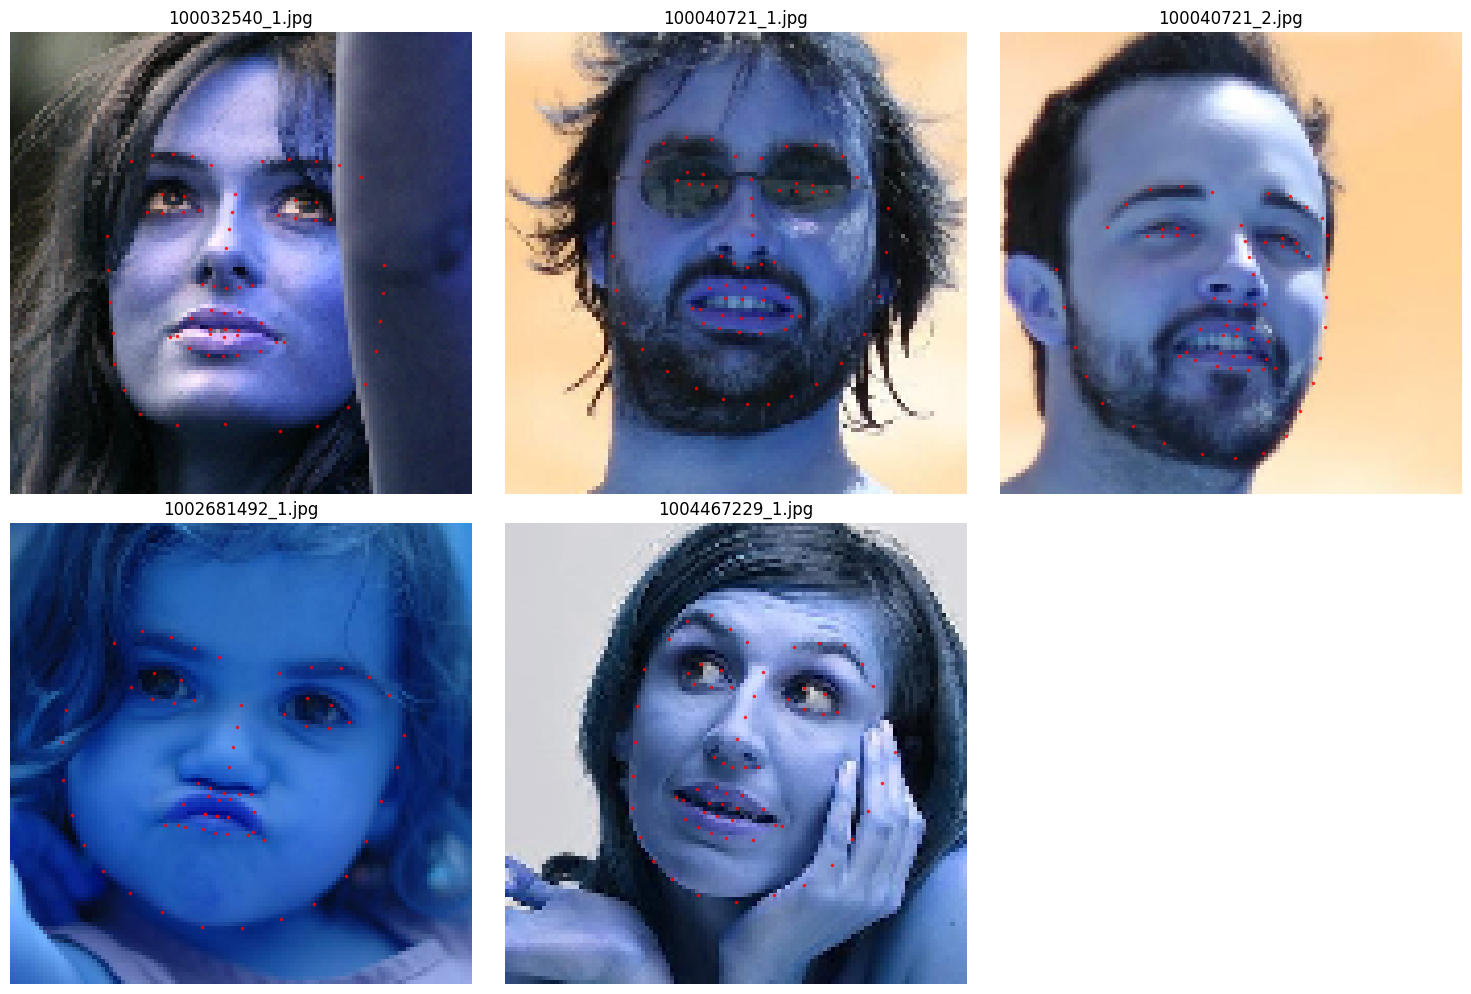

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

# Путь к папке с обработанными данными
processed_dir = '/content/processed'
image_paths = sorted(glob(os.path.join(processed_dir, '*.jpg')))[:10]  # Первые 10 изображений

def load_data(image_path):
    npy_path = image_path.replace('.jpg', '.npy')
    if not os.path.exists(npy_path):
        raise FileNotFoundError(f"Файл {npy_path} не найден")

    data = np.load(npy_path, allow_pickle=True).item()  # Загружаем словарь
    return data['image'], data['landmarks']

# Визуализация
plt.figure(figsize=(15, 10))
plotted = 0

for i, img_path in enumerate(image_paths):
    if plotted >= 5:
        break

    try:
        # Загрузка данных
        img, landmarks = load_data(img_path)

        # Если изображение в BGR (как в вашем случае), конвертируем в RGB
        if isinstance(img, np.ndarray) and img.ndim == 3 and img.shape[2] == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Отрисовка
        plt.subplot(2, 3, plotted+1)
        plt.imshow(img)
        plt.scatter(landmarks[:, 0] * img.shape[1],  # Масштабируем X к пикселям
                  landmarks[:, 1] * img.shape[0],  # Масштабируем Y к пикселям
                  c='red', s=10, marker='.', alpha=0.7)
        plt.title(os.path.basename(img_path))
        plt.axis('off')
        plotted += 1

    except Exception as e:
        print(f"Ошибка обработки {img_path}: {str(e)}")

if plotted == 0:
    print("Не удалось обработать ни одного изображения!")
else:
    plt.tight_layout()
    plt.show()

Распаковываем /content/drive/MyDrive/Facial_Keypoint/processed.zip...
Готово!
Загружено 8293 пар (jpg+npy)

Проверка первого образца:
Ключи: dict_keys(['image', 'landmarks', 'bbox', 'orig_size'])
Размер изображения: (112, 112, 3)
Количество точек: (68, 2)


Validating dataset: 100%|██████████| 6634/6634 [00:00<00:00, 8190.46it/s]



Successfully loaded 6189 samples (skipped 445 invalid)


Validating dataset: 100%|██████████| 1659/1659 [00:00<00:00, 8274.78it/s]



Successfully loaded 1554 samples (skipped 105 invalid)

Проверка качества данных (train):
Первый образец:
Тип: <class 'dict'>
Ключи: dict_keys(['image', 'landmarks', 'bbox', 'orig_size'])
Изображение: torch.Size([3, 112, 112]) torch.float32
Landmarks: torch.Size([136]) torch.float32
Sample 11 содержит нулевые данные!
Найдено 1 проблемных образцов из 100 проверенных

Проверка качества данных (val):
Первый образец:
Тип: <class 'dict'>
Ключи: dict_keys(['image', 'landmarks', 'bbox', 'orig_size'])
Изображение: torch.Size([3, 112, 112]) torch.float32
Landmarks: torch.Size([136]) torch.float32
Sample 43 содержит нулевые данные!
Найдено 1 проблемных образцов из 100 проверенных

Проверка батча из train_loader:


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Изображения: torch.Size([32, 3, 112, 112]) torch.float32
Landmarks: torch.Size([32, 136]) torch.float32


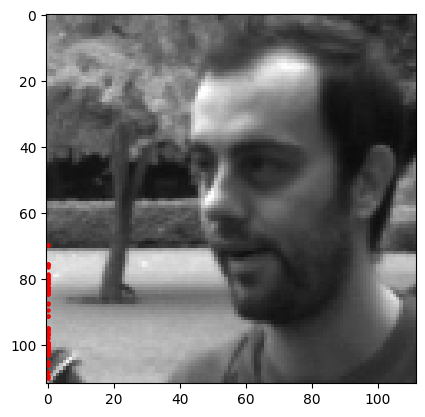

Epoch 1: 100%|██████████| 193/193 [00:10<00:00, 18.66it/s]


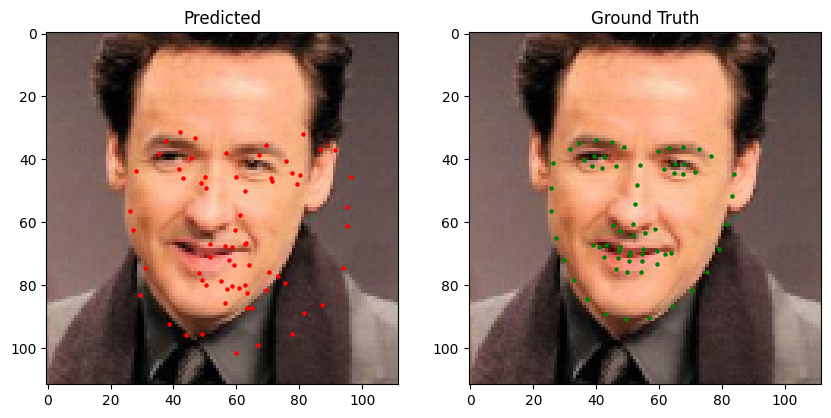

Epoch 1: Train Loss: 0.4630 | Val Loss: 0.0063


Epoch 2: 100%|██████████| 193/193 [00:07<00:00, 24.29it/s]


Epoch 2: Train Loss: 0.2918 | Val Loss: 0.2666


Epoch 3: 100%|██████████| 193/193 [00:08<00:00, 21.89it/s]


Epoch 3: Train Loss: 0.2709 | Val Loss: 0.2855


Epoch 4: 100%|██████████| 193/193 [00:09<00:00, 20.14it/s]


Epoch 4: Train Loss: 0.2598 | Val Loss: 0.2751


Epoch 5: 100%|██████████| 193/193 [00:08<00:00, 23.80it/s]


Epoch 5: Train Loss: 0.2524 | Val Loss: 0.2297


Epoch 6: 100%|██████████| 193/193 [00:08<00:00, 22.39it/s]


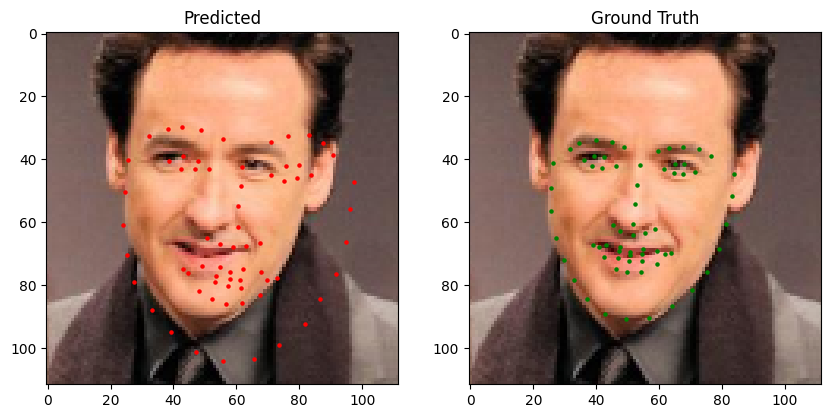

Epoch 6: Train Loss: 0.2486 | Val Loss: 0.0057


Epoch 7: 100%|██████████| 193/193 [00:09<00:00, 21.27it/s]


Epoch 7: Train Loss: 0.2431 | Val Loss: 0.2418


Epoch 8: 100%|██████████| 193/193 [00:08<00:00, 22.46it/s]


Epoch 8: Train Loss: 0.2403 | Val Loss: 0.2451


Epoch 9: 100%|██████████| 193/193 [00:08<00:00, 22.95it/s]


Epoch 9: Train Loss: 0.2331 | Val Loss: 0.2805


Epoch 10: 100%|██████████| 193/193 [00:08<00:00, 21.49it/s]


Epoch 10: Train Loss: 0.2297 | Val Loss: 0.2763


Epoch 11: 100%|██████████| 193/193 [00:08<00:00, 21.94it/s]


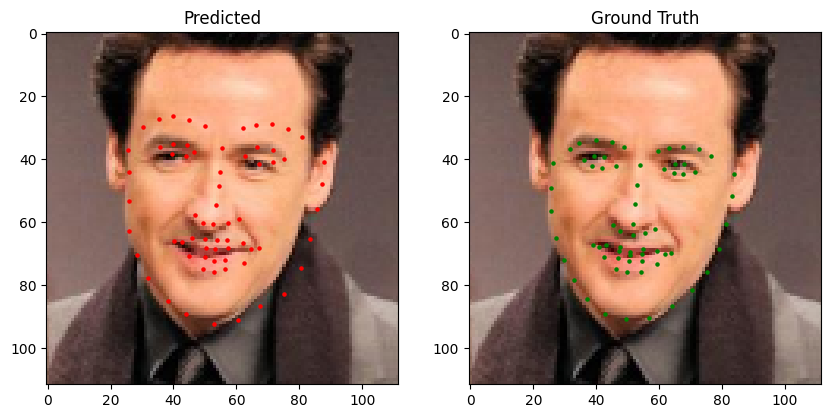

Epoch 11: Train Loss: 0.2265 | Val Loss: 0.0036


Epoch 12: 100%|██████████| 193/193 [00:08<00:00, 23.70it/s]


Epoch 12: Train Loss: 0.2220 | Val Loss: 0.2306


Epoch 13: 100%|██████████| 193/193 [00:09<00:00, 21.25it/s]


Epoch 13: Train Loss: 0.2182 | Val Loss: 0.2394


Epoch 14: 100%|██████████| 193/193 [00:08<00:00, 21.52it/s]


Epoch 14: Train Loss: 0.2154 | Val Loss: 0.2363


Epoch 15: 100%|██████████| 193/193 [00:08<00:00, 23.38it/s]


Epoch 15: Train Loss: 0.2096 | Val Loss: 0.2391


Epoch 16: 100%|██████████| 193/193 [00:08<00:00, 21.96it/s]


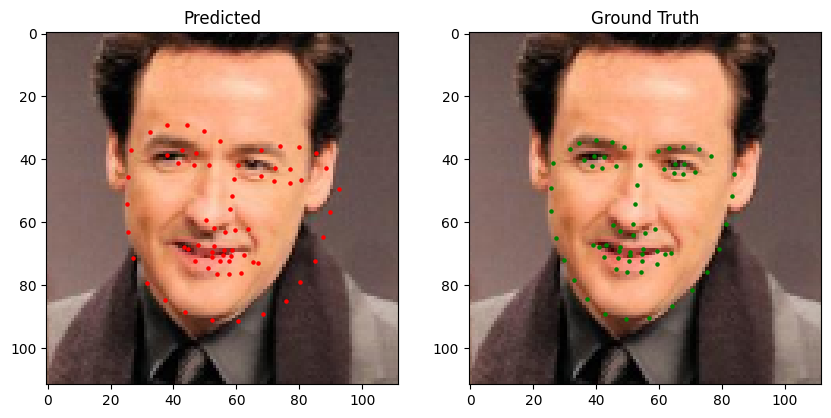

Epoch 16: Train Loss: 0.2079 | Val Loss: 0.0042


Epoch 17: 100%|██████████| 193/193 [00:09<00:00, 21.22it/s]


Epoch 17: Train Loss: 0.2041 | Val Loss: 0.2103


Epoch 18: 100%|██████████| 193/193 [00:08<00:00, 22.89it/s]


Epoch 18: Train Loss: 0.1934 | Val Loss: 0.1884


Epoch 19: 100%|██████████| 193/193 [00:08<00:00, 22.79it/s]


Epoch 19: Train Loss: 0.1890 | Val Loss: 0.1883


Epoch 20: 100%|██████████| 193/193 [00:09<00:00, 21.42it/s]


Epoch 20: Train Loss: 0.1876 | Val Loss: 0.1924


Epoch 21: 100%|██████████| 193/193 [00:08<00:00, 22.03it/s]


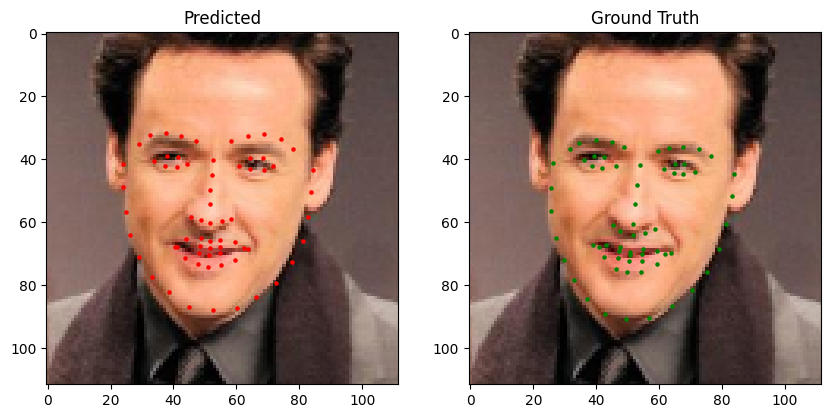

Epoch 21: Train Loss: 0.1846 | Val Loss: 0.0028


Epoch 22: 100%|██████████| 193/193 [00:08<00:00, 23.42it/s]


Epoch 22: Train Loss: 0.1835 | Val Loss: 0.2235


Epoch 23: 100%|██████████| 193/193 [00:09<00:00, 21.11it/s]


Epoch 23: Train Loss: 0.1824 | Val Loss: 0.1958


Epoch 24: 100%|██████████| 193/193 [00:09<00:00, 21.38it/s]


Epoch 24: Train Loss: 0.1796 | Val Loss: 0.2001


Epoch 25: 100%|██████████| 193/193 [00:08<00:00, 23.53it/s]


Epoch 25: Train Loss: 0.1769 | Val Loss: 0.2133


Epoch 26: 100%|██████████| 193/193 [00:08<00:00, 21.74it/s]


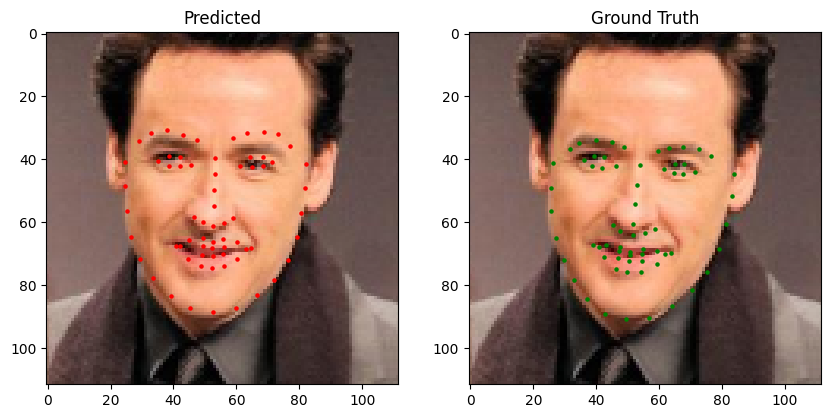

Epoch 26: Train Loss: 0.1759 | Val Loss: 0.0027


Epoch 27: 100%|██████████| 193/193 [00:09<00:00, 21.19it/s]


Epoch 27: Train Loss: 0.1748 | Val Loss: 0.2298


Epoch 28: 100%|██████████| 193/193 [00:08<00:00, 22.46it/s]


Epoch 28: Train Loss: 0.1733 | Val Loss: 0.1854


Epoch 29: 100%|██████████| 193/193 [00:08<00:00, 22.76it/s]


Epoch 29: Train Loss: 0.1719 | Val Loss: 0.2133


Epoch 30: 100%|██████████| 193/193 [00:09<00:00, 21.39it/s]


Epoch 30: Train Loss: 0.1711 | Val Loss: 0.2577


Epoch 31: 100%|██████████| 193/193 [00:08<00:00, 21.49it/s]


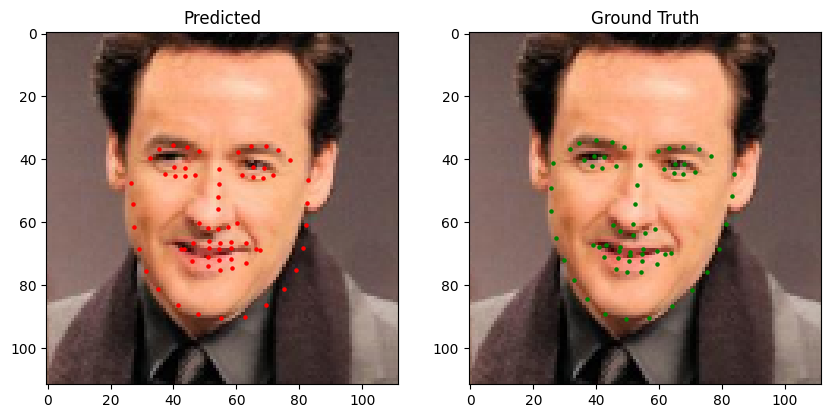

Epoch 31: Train Loss: 0.1698 | Val Loss: 0.0028


Epoch 32: 100%|██████████| 193/193 [00:08<00:00, 23.12it/s]


Epoch 32: Train Loss: 0.1682 | Val Loss: 0.1958


Epoch 33: 100%|██████████| 193/193 [00:09<00:00, 20.92it/s]


Epoch 33: Train Loss: 0.1614 | Val Loss: 0.1811


Epoch 34: 100%|██████████| 193/193 [00:09<00:00, 21.37it/s]


Epoch 34: Train Loss: 0.1595 | Val Loss: 0.1868


Epoch 35: 100%|██████████| 193/193 [00:08<00:00, 23.17it/s]


Epoch 35: Train Loss: 0.1575 | Val Loss: 0.1794


Epoch 36: 100%|██████████| 193/193 [00:08<00:00, 22.24it/s]


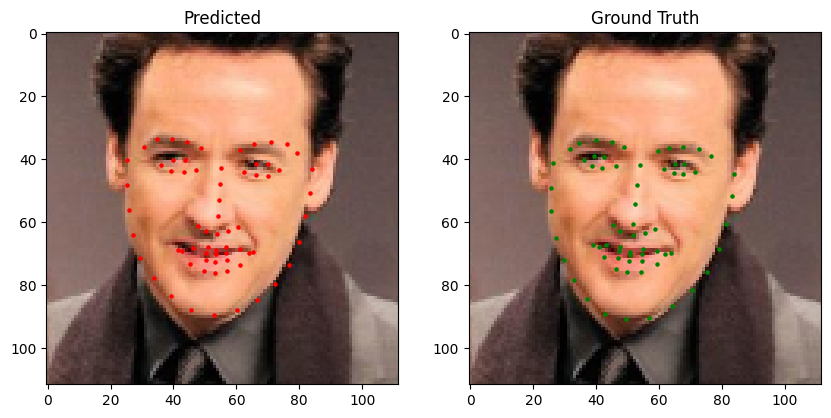

Epoch 36: Train Loss: 0.1573 | Val Loss: 0.0026


Epoch 37: 100%|██████████| 193/193 [00:09<00:00, 20.99it/s]


Epoch 37: Train Loss: 0.1557 | Val Loss: 0.1747


Epoch 38: 100%|██████████| 193/193 [00:08<00:00, 22.10it/s]


Epoch 38: Train Loss: 0.1553 | Val Loss: 0.1913


Epoch 39: 100%|██████████| 193/193 [00:08<00:00, 23.06it/s]


Epoch 39: Train Loss: 0.1538 | Val Loss: 0.1785


Epoch 40: 100%|██████████| 193/193 [00:09<00:00, 21.22it/s]


Epoch 40: Train Loss: 0.1537 | Val Loss: 0.1802


Epoch 41: 100%|██████████| 193/193 [00:09<00:00, 20.89it/s]


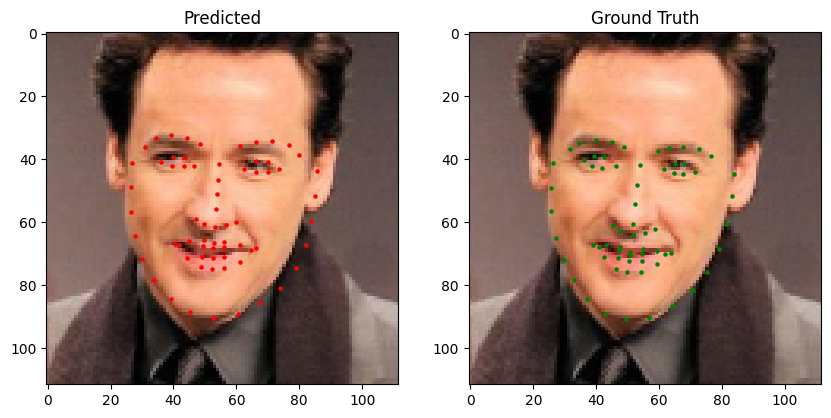

Epoch 41: Train Loss: 0.1522 | Val Loss: 0.0026


Epoch 42: 100%|██████████| 193/193 [00:08<00:00, 22.05it/s]


Epoch 42: Train Loss: 0.1514 | Val Loss: 0.1892


Epoch 43: 100%|██████████| 193/193 [00:09<00:00, 20.17it/s]


Epoch 43: Train Loss: 0.1511 | Val Loss: 0.1852


Epoch 44: 100%|██████████| 193/193 [00:09<00:00, 19.99it/s]


Epoch 44: Train Loss: 0.1503 | Val Loss: 0.1846


Epoch 45: 100%|██████████| 193/193 [00:09<00:00, 20.54it/s]


Epoch 45: Train Loss: 0.1502 | Val Loss: 0.1790


Epoch 46: 100%|██████████| 193/193 [00:08<00:00, 21.93it/s]


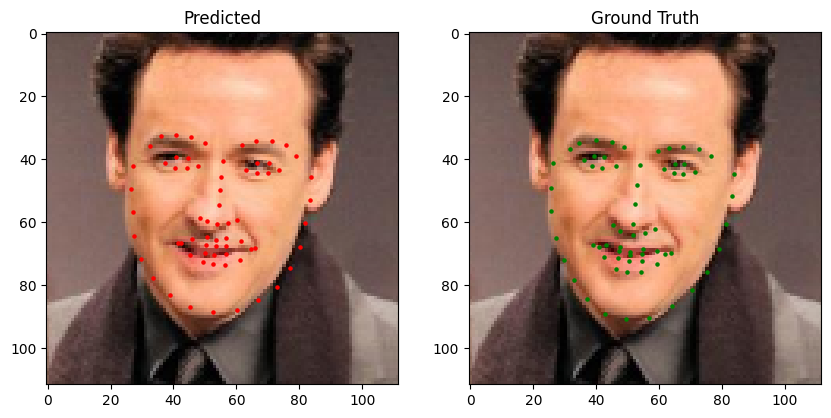

Epoch 46: Train Loss: 0.1483 | Val Loss: 0.0025


Epoch 47: 100%|██████████| 193/193 [00:09<00:00, 21.44it/s]


Epoch 47: Train Loss: 0.1486 | Val Loss: 0.1800


Epoch 48: 100%|██████████| 193/193 [00:09<00:00, 20.96it/s]


Epoch 48: Train Loss: 0.1478 | Val Loss: 0.1811


Epoch 49: 100%|██████████| 193/193 [00:08<00:00, 22.07it/s]


Epoch 49: Train Loss: 0.1454 | Val Loss: 0.1842


Epoch 50: 100%|██████████| 193/193 [00:08<00:00, 22.80it/s]


Epoch 50: Train Loss: 0.1460 | Val Loss: 0.1932


Epoch 51: 100%|██████████| 193/193 [00:09<00:00, 20.73it/s]


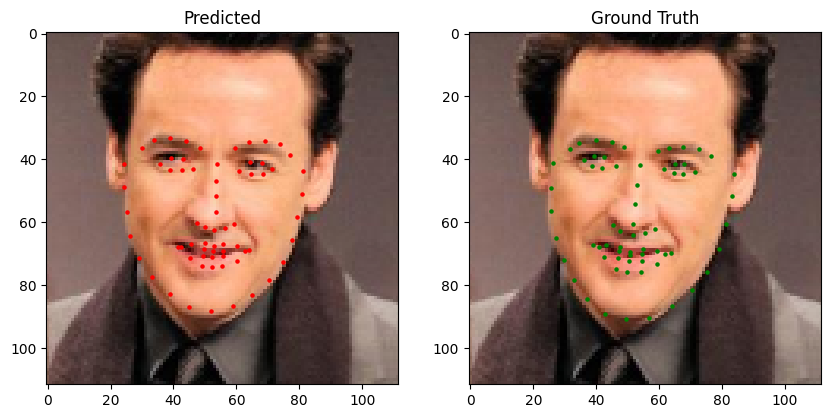

Epoch 51: Train Loss: 0.1458 | Val Loss: 0.0028


Epoch 52: 100%|██████████| 193/193 [00:09<00:00, 21.40it/s]


Epoch 52: Train Loss: 0.1444 | Val Loss: 0.1823


Epoch 53: 100%|██████████| 193/193 [00:08<00:00, 22.91it/s]


Epoch 53: Train Loss: 0.1407 | Val Loss: 0.1862


Epoch 54: 100%|██████████| 193/193 [00:09<00:00, 21.12it/s]


Epoch 54: Train Loss: 0.1393 | Val Loss: 0.1775


Epoch 55: 100%|██████████| 193/193 [00:09<00:00, 20.72it/s]


Epoch 55: Train Loss: 0.1389 | Val Loss: 0.1830


Epoch 56: 100%|██████████| 193/193 [00:08<00:00, 21.96it/s]


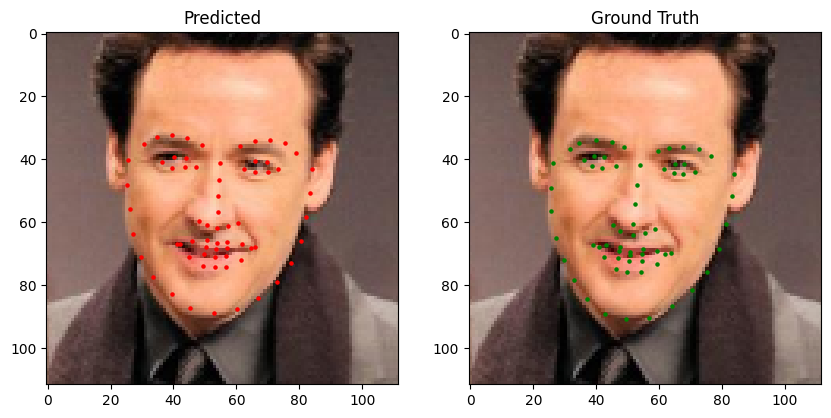

Epoch 56: Train Loss: 0.1381 | Val Loss: 0.0025


Epoch 57: 100%|██████████| 193/193 [00:08<00:00, 22.05it/s]


Epoch 57: Train Loss: 0.1377 | Val Loss: 0.1832


Epoch 58: 100%|██████████| 193/193 [00:09<00:00, 20.69it/s]


Epoch 58: Train Loss: 0.1361 | Val Loss: 0.1800


Epoch 59: 100%|██████████| 193/193 [00:09<00:00, 21.11it/s]


Epoch 59: Train Loss: 0.1345 | Val Loss: 0.1822


Epoch 60: 100%|██████████| 193/193 [00:08<00:00, 22.95it/s]


Epoch 60: Train Loss: 0.1339 | Val Loss: 0.1809


Epoch 61: 100%|██████████| 193/193 [00:09<00:00, 20.64it/s]


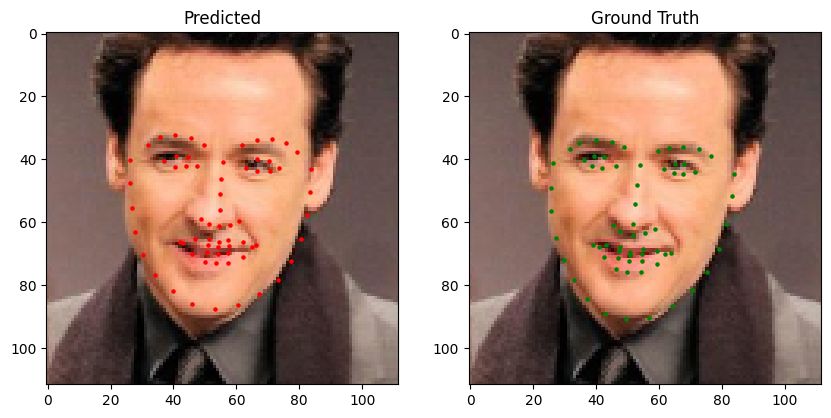

Epoch 61: Train Loss: 0.1333 | Val Loss: 0.0026


Epoch 62: 100%|██████████| 193/193 [00:09<00:00, 20.29it/s]


Epoch 62: Train Loss: 0.1334 | Val Loss: 0.1805


Epoch 63: 100%|██████████| 193/193 [00:08<00:00, 22.70it/s]


Epoch 63: Train Loss: 0.1335 | Val Loss: 0.1805


Epoch 64: 100%|██████████| 193/193 [00:08<00:00, 21.76it/s]


Epoch 64: Train Loss: 0.1325 | Val Loss: 0.1844


Epoch 65: 100%|██████████| 193/193 [00:09<00:00, 20.71it/s]


Epoch 65: Train Loss: 0.1312 | Val Loss: 0.1805


Epoch 66: 100%|██████████| 193/193 [00:08<00:00, 21.58it/s]


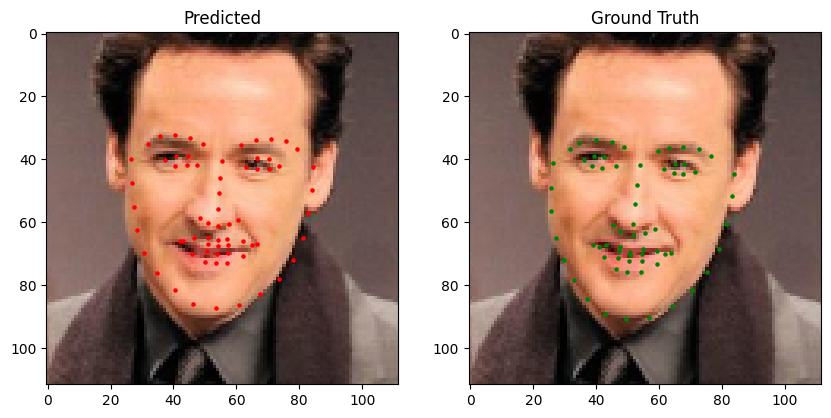

Epoch 66: Train Loss: 0.1311 | Val Loss: 0.0026


Epoch 67: 100%|██████████| 193/193 [00:08<00:00, 22.69it/s]


Epoch 67: Train Loss: 0.1311 | Val Loss: 0.1819


Epoch 68: 100%|██████████| 193/193 [00:09<00:00, 20.54it/s]


Epoch 68: Train Loss: 0.1307 | Val Loss: 0.1818


Epoch 69: 100%|██████████| 193/193 [00:09<00:00, 20.81it/s]


Epoch 69: Train Loss: 0.1305 | Val Loss: 0.1832


Epoch 70: 100%|██████████| 193/193 [00:08<00:00, 23.01it/s]


Epoch 70: Train Loss: 0.1296 | Val Loss: 0.1812


Epoch 71: 100%|██████████| 193/193 [00:09<00:00, 20.95it/s]


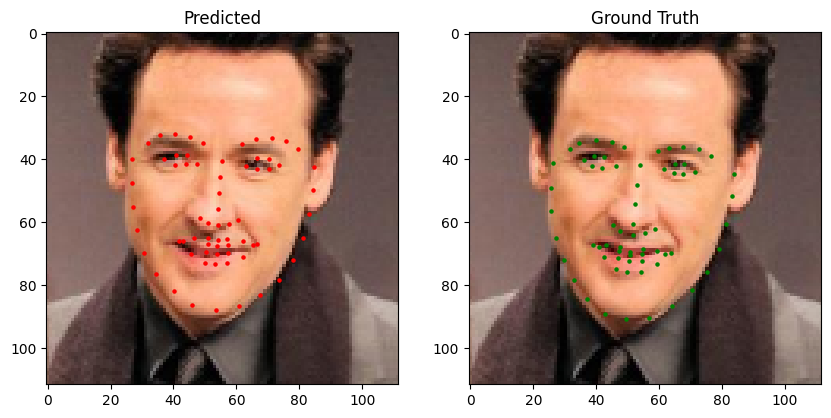

Epoch 71: Train Loss: 0.1293 | Val Loss: 0.0027


Epoch 72: 100%|██████████| 193/193 [00:09<00:00, 20.70it/s]


Epoch 72: Train Loss: 0.1293 | Val Loss: 0.1819


Epoch 73: 100%|██████████| 193/193 [00:08<00:00, 22.61it/s]


Epoch 73: Train Loss: 0.1300 | Val Loss: 0.1823


Epoch 74: 100%|██████████| 193/193 [00:08<00:00, 21.88it/s]


Epoch 74: Train Loss: 0.1292 | Val Loss: 0.1825


Epoch 75: 100%|██████████| 193/193 [00:09<00:00, 20.69it/s]


Epoch 75: Train Loss: 0.1294 | Val Loss: 0.1820


Epoch 76: 100%|██████████| 193/193 [00:09<00:00, 21.02it/s]


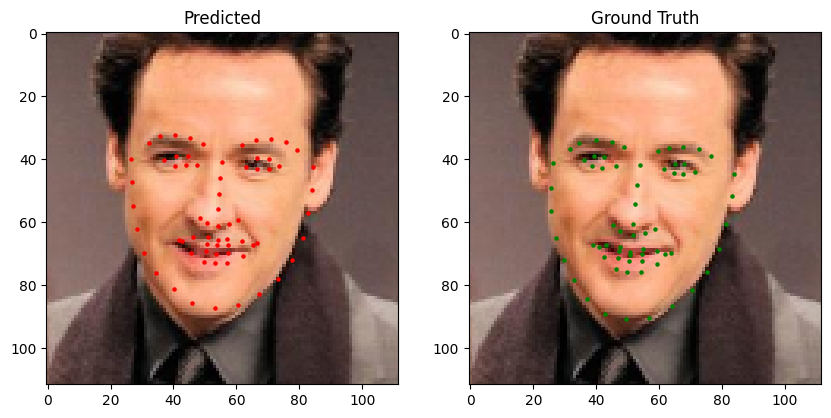

Epoch 76: Train Loss: 0.1283 | Val Loss: 0.0026


Epoch 77: 100%|██████████| 193/193 [00:08<00:00, 22.87it/s]


Epoch 77: Train Loss: 0.1278 | Val Loss: 0.1824


Epoch 78: 100%|██████████| 193/193 [00:09<00:00, 20.55it/s]


Epoch 78: Train Loss: 0.1278 | Val Loss: 0.1828


Epoch 79: 100%|██████████| 193/193 [00:09<00:00, 20.82it/s]


Epoch 79: Train Loss: 0.1275 | Val Loss: 0.1816


Epoch 80: 100%|██████████| 193/193 [00:08<00:00, 22.73it/s]


Epoch 80: Train Loss: 0.1285 | Val Loss: 0.1825


Epoch 81: 100%|██████████| 193/193 [00:08<00:00, 21.70it/s]


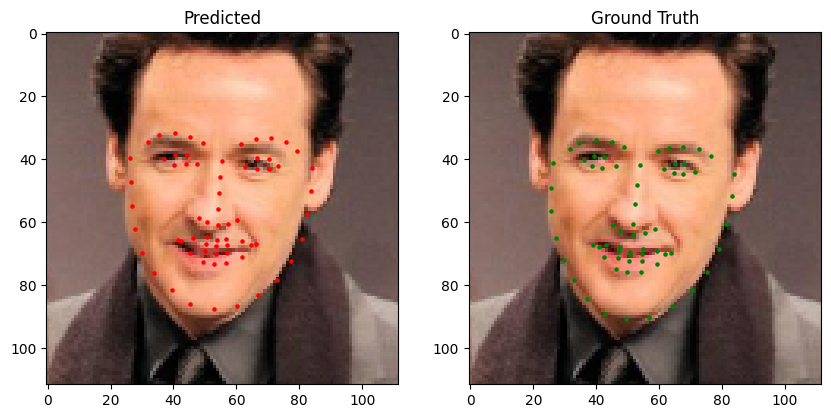

Epoch 81: Train Loss: 0.1288 | Val Loss: 0.0026


Epoch 82: 100%|██████████| 193/193 [00:09<00:00, 20.63it/s]


Epoch 82: Train Loss: 0.1284 | Val Loss: 0.1825


Epoch 83: 100%|██████████| 193/193 [00:08<00:00, 21.84it/s]


Epoch 83: Train Loss: 0.1279 | Val Loss: 0.1822


Epoch 84: 100%|██████████| 193/193 [00:08<00:00, 22.50it/s]


Epoch 84: Train Loss: 0.1281 | Val Loss: 0.1820


Epoch 85: 100%|██████████| 193/193 [00:09<00:00, 20.40it/s]


Epoch 85: Train Loss: 0.1282 | Val Loss: 0.1827


Epoch 86: 100%|██████████| 193/193 [00:09<00:00, 20.38it/s]


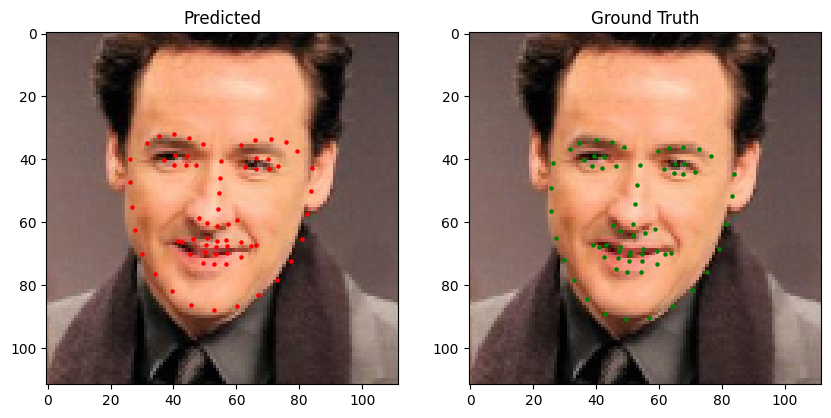

Epoch 86: Train Loss: 0.1283 | Val Loss: 0.0027


Epoch 87: 100%|██████████| 193/193 [00:08<00:00, 22.70it/s]


Epoch 87: Train Loss: 0.1285 | Val Loss: 0.1832


Epoch 88: 100%|██████████| 193/193 [00:09<00:00, 20.74it/s]


Epoch 88: Train Loss: 0.1274 | Val Loss: 0.1827


Epoch 89: 100%|██████████| 193/193 [00:09<00:00, 20.63it/s]


Epoch 89: Train Loss: 0.1267 | Val Loss: 0.1828


Epoch 90: 100%|██████████| 193/193 [00:08<00:00, 22.65it/s]


Epoch 90: Train Loss: 0.1268 | Val Loss: 0.1830


Epoch 91: 100%|██████████| 193/193 [00:08<00:00, 21.62it/s]


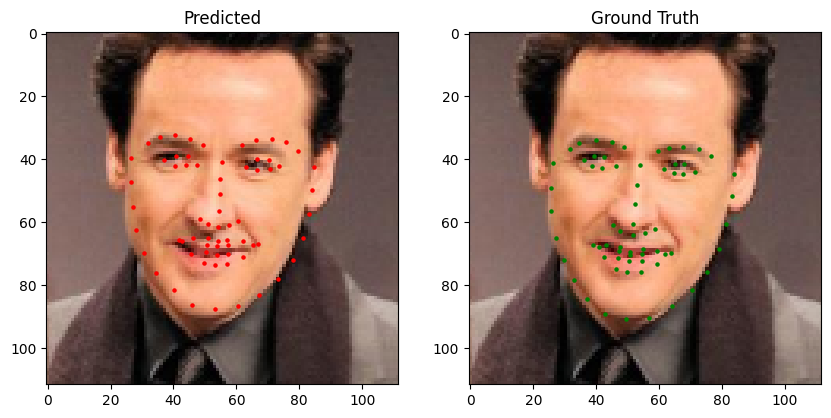

Epoch 91: Train Loss: 0.1273 | Val Loss: 0.0027


Epoch 92: 100%|██████████| 193/193 [00:09<00:00, 20.48it/s]


Epoch 92: Train Loss: 0.1267 | Val Loss: 0.1827


Epoch 93: 100%|██████████| 193/193 [00:08<00:00, 21.56it/s]


Epoch 93: Train Loss: 0.1277 | Val Loss: 0.1826


Epoch 94: 100%|██████████| 193/193 [00:08<00:00, 22.89it/s]


Epoch 94: Train Loss: 0.1277 | Val Loss: 0.1826


Epoch 95: 100%|██████████| 193/193 [00:09<00:00, 19.94it/s]


Epoch 95: Train Loss: 0.1268 | Val Loss: 0.1827


Epoch 96: 100%|██████████| 193/193 [00:09<00:00, 20.47it/s]


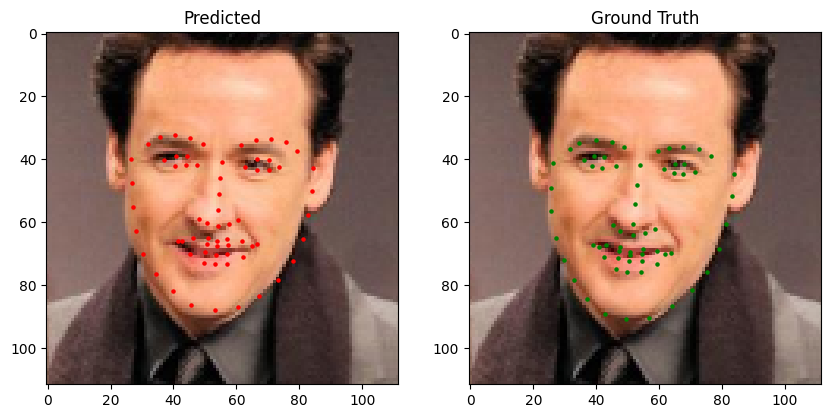

Epoch 96: Train Loss: 0.1271 | Val Loss: 0.0026


Epoch 97: 100%|██████████| 193/193 [00:08<00:00, 22.77it/s]


Epoch 97: Train Loss: 0.1271 | Val Loss: 0.1826


Epoch 98: 100%|██████████| 193/193 [00:09<00:00, 20.79it/s]


Epoch 98: Train Loss: 0.1268 | Val Loss: 0.1830


Epoch 99: 100%|██████████| 193/193 [00:09<00:00, 20.67it/s]


Epoch 99: Train Loss: 0.1280 | Val Loss: 0.1832


Epoch 100: 100%|██████████| 193/193 [00:08<00:00, 22.14it/s]


Epoch 100: Train Loss: 0.1271 | Val Loss: 0.1826
Обучение завершено!


In [12]:
import glob
archive_path = '/content/drive/MyDrive/Facial_Keypoint/processed.zip'
extract_dir = 'processed'

if os.path.exists(archive_path):
    print(f"Распаковываем {archive_path}...")
    with zipfile.ZipFile(archive_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print("Готово!")
else:
    raise FileNotFoundError(f"Архив не найден по пути: {archive_path}")

samples = []
for data_path in glob.glob(os.path.join(extract_dir, '*.npy')):
    img_path = data_path.replace('.npy', '.jpg')
    if os.path.exists(img_path):
        samples.append((img_path, data_path))

print(f"Загружено {len(samples)} пар (jpg+npy)")

# Быстрая проверка первого образца
if samples:
    sample_data = np.load(samples[0][1], allow_pickle=True).item()
    print("\nПроверка первого образца:")
    print("Ключи:", sample_data.keys())
    print("Размер изображения:", sample_data['image'].shape)
    print("Количество точек:", sample_data['landmarks'].shape)


# Запуск обучения
if samples:
    model = train_model(samples)
else:
    print("Ошибка: не найдены данные для обучения")

In [13]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bunzip2 shape_predictor_68_face_landmarks.dat.bz2

--2025-07-09 16:05:39--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 [following]
--2025-07-09 16:05:39--  https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Connecting to dlib.net (dlib.net)|107.180.26.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  14.4MB/s    in 5.1s    

2025-07-09 16:05:45 (12.0 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [14]:
import os
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import auc
from collections import defaultdict

# Инициализация детектора DLIB и предиктора для сравнения
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')  # Нужно скачать модель

# Функция для загрузки тестовых данных
def load_test_data(test_dir):
    samples = []
    pts_files = list(Path(test_dir).rglob("*.pts"))

    for pts_path in pts_files:
        with open(pts_path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                if 'n_points' in line:
                    n_points = int(line.strip().split(':')[1])
                    break

            # Пропускаем изображения с 39 точками
            if n_points == 39:
                continue

            img_path = pts_path.with_suffix('.jpg')
            if img_path.exists():
                samples.append((str(img_path), str(pts_path)))

    return samples

# Функция для обработки тестового образца (аналогично train, но без нормализации)
def process_test_sample(img_path, pts_path):
    try:
        img = cv2.imread(img_path)
        if img is None:
            return None

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        landmarks = load_pts(pts_path)

        if landmarks is None or len(landmarks) != 68:
            return None

        # Детекция лица
        dets = detector(img, 1)
        if not dets:
            return None

        bbox = dets[0]
        x1, y1, x2, y2 = bbox.left(), bbox.top(), bbox.right(), bbox.bottom()
        w, h = x2 - x1, y2 - y1

        # Увеличиваем margin (30%)
        margin = 0.3
        x1 = max(0, int(x1 - margin * w))
        y1 = max(0, int(y1 - margin * h))
        x2 = min(img.shape[1], int(x2 + margin * w))
        y2 = min(img.shape[0], int(y2 + margin * h))

        if x1 >= x2 or y1 >= y2:
            return None

        # Crop и resize до 112x112
        face_crop = img[y1:y2, x1:x2]
        face_resized = cv2.resize(face_crop, (112, 112))

        return {
            'image': face_resized,
            'landmarks': landmarks,  # Оригинальные координаты (не нормализованные)
            'bbox': [x1, y1, x2, y2],
            'orig_img': img,
            'img_path': img_path
        }
    except Exception as e:
        print(f"Error in {img_path}: {str(e)}")
        return None

# Датасет для тестирования
class TestDataset(Dataset):
    def __init__(self, samples):
        self.samples = []
        self.invalid_count = 0

        for img_path, pts_path in tqdm(samples, desc="Loading test data"):
            data = process_test_sample(img_path, pts_path)
            if data is not None:
                self.samples.append(data)
            else:
                self.invalid_count += 1

        print(f"Loaded {len(self.samples)} valid samples, skipped {self.invalid_count} invalid")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        data = self.samples[idx]

        # Нормализация изображения для модели
        image = data['image'].astype(np.float32) / 255.0
        image = torch.tensor(image).permute(2, 0, 1)  # (C, H, W)

        return {
            'image': image,
            'landmarks': torch.tensor(data['landmarks']),
            'bbox': torch.tensor(data['bbox']),
            'orig_img': data['orig_img'],
            'img_path': data['img_path']
        }

In [15]:
# Функция для расчета ошибки
def calculate_nme(pred_landmarks, true_landmarks, bbox):
    """
    Calculate Normalized Mean Error (NME)
    :param pred_landmarks: predicted landmarks (68, 2)
    :param true_landmarks: ground truth landmarks (68, 2)
    :param bbox: bounding box [x1, y1, x2, y2]
    :return: NME
    """
    # Размер bbox для нормализации
    w = bbox[2] - bbox[0]
    h = bbox[3] - bbox[1]
    norm_factor = np.sqrt(w * h)

    # Среднеквадратичная ошибка
    mse = np.mean(np.sqrt(np.sum((pred_landmarks - true_landmarks) ** 2, axis=1)))

    # Нормализованная ошибка
    nme = mse / norm_factor
    return nme

# Функция для предсказания с помощью нашей модели
def predict_with_model(model, sample, device):
    model.eval()
    with torch.no_grad():
        # Убедимся, что изображение имеет правильную размерность (C, H, W)
        image = sample['image'].to(device)

        # Добавляем batch dimension если его нет
        if image.dim() == 3:
            image = image.unsqueeze(0)  # (1, C, H, W)

        pred = model(image).cpu().numpy().reshape(-1, 2)

        # Денормализация предсказанных точек к оригинальному размеру 112x112
        pred = pred * 112

        # Масштабирование точек к оригинальному bbox
        bbox = sample['bbox'].cpu().numpy()
        w_scale = (bbox[2] - bbox[0]) / 112
        h_scale = (bbox[3] - bbox[1]) / 112

        pred[:, 0] = pred[:, 0] * w_scale + bbox[0]
        pred[:, 1] = pred[:, 1] * h_scale + bbox[1]

        return pred

# Функция для предсказания с помощью DLIB
def predict_with_dlib(sample):
    try:
        # Преобразуем изображение из тензора в numpy array
        if isinstance(sample['orig_img'], torch.Tensor):
            orig_img = sample['orig_img'].cpu().numpy()
        else:
            orig_img = sample['orig_img']

        # Убедимся, что изображение в правильном формате (uint8, BGR)
        if orig_img.dtype != np.uint8:
            orig_img = (orig_img * 255).astype(np.uint8)
        if len(orig_img.shape) == 3 and orig_img.shape[0] == 3:  # CHW -> HWC
            orig_img = orig_img.transpose(1, 2, 0)
        if orig_img.shape[2] == 3:  # RGB -> BGR
            orig_img = orig_img[:, :, ::-1]

        # Преобразуем bbox в dlib.rectangle
        bbox = sample['bbox']
        if isinstance(bbox, torch.Tensor):
            bbox = bbox.cpu().numpy()
        dlib_rect = dlib.rectangle(*bbox.astype(int))

        # Предсказание ключевых точек
        shape = predictor(orig_img, dlib_rect)
        landmarks = np.array([[p.x, p.y] for p in shape.parts()])
        return landmarks
    except Exception as e:
        print(f"DLIB prediction failed: {str(e)}")
        return None

# Функция для построения CED графиков
def plot_ced(errors_dict, max_error=0.08, title="Cumulative Error Distribution"):
    plt.figure(figsize=(10, 6))

    for method, errors in errors_dict.items():
        # Сортировка ошибок
        sorted_errors = np.sort(errors)

        # Рассчет CED
        y = np.arange(1, len(sorted_errors)+1) / len(sorted_errors)
        x = sorted_errors

        # Обрезаем до max_error
        mask = x <= max_error
        x = x[mask]
        y = y[mask]

        # Рассчет AUC
        auc_score = auc(x, y) / max_error

        plt.plot(x, y, label=f"{method} (AUC: {auc_score:.3f})")

    plt.xlabel("Normalized Mean Error")
    plt.ylabel("Fraction of Images")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.xlim(0, max_error)
    plt.ylim(0, 1)
    plt.show()

# Основная функция тестирования
def evaluate_model(model, test_dirs, device):
    # Загрузка тестовых данных
    test_samples = []
    for test_dir in test_dirs:
        test_samples += load_test_data(test_dir)

    test_dataset = TestDataset(test_samples)
    test_loader = DataLoader(
        test_dataset,
        batch_size=1,
        shuffle=False,
        num_workers=2
    )

    # Словари для хранения ошибок
    errors = defaultdict(lambda: defaultdict(list))
    dlib_fail_count = 0

    # Тестирование
    for batch in tqdm(test_loader, desc="Evaluating"):
        img_path = batch['img_path'][0]
        dataset_name = "300W" if "300W" in img_path else "Menpo"

        # Подготовка данных
        sample = {
            'image': batch['image'].squeeze(0).to(device),
            'landmarks': batch['landmarks'].squeeze(0),
            'bbox': batch['bbox'].squeeze(0),
            'orig_img': batch['orig_img'][0]
        }

        # Предсказание нашей моделью
        pred_landmarks_model = predict_with_model(model, sample, device)
        true_landmarks = sample['landmarks'].cpu().numpy()
        bbox = sample['bbox'].cpu().numpy()

        # Расчет ошибки для нашей модели
        nme_model = calculate_nme(pred_landmarks_model, true_landmarks, bbox)
        errors[dataset_name]['Our Model'].append(nme_model)

        # Только для Menpo сравниваем с DLIB
        if dataset_name == "Menpo":
            pred_landmarks_dlib = predict_with_dlib(sample)
            if pred_landmarks_dlib is not None:
                nme_dlib = calculate_nme(pred_landmarks_dlib, true_landmarks, bbox)
                errors[dataset_name]['DLIB'].append(nme_dlib)
            else:
                dlib_fail_count += 1

    print(f"\nDLIB failed to predict on {dlib_fail_count} samples")

    # Построение графиков
    for dataset_name in errors:
        plot_ced(errors[dataset_name],
                max_error=0.08,
                title=f"CED Curve - {dataset_name} Dataset")

    # Сохранение результатов
    results = {}
    for dataset_name in errors:
        results[dataset_name] = {}
        for method in errors[dataset_name]:
            errors_array = np.array(errors[dataset_name][method])
            results[dataset_name][method] = {
                'mean': np.mean(errors_array),
                'std': np.std(errors_array),
                'median': np.median(errors_array),
                'max': np.max(errors_array),
                'min': np.min(errors_array),
                'samples': len(errors_array)
            }

    print("\nResults Summary:")
    print(json.dumps(results, indent=4))

    return results

Loading test data: 100%|██████████| 942/942 [10:05<00:00,  1.55it/s]


Loaded 853 valid samples, skipped 89 invalid


Evaluating: 100%|██████████| 853/853 [00:13<00:00, 63.05it/s]



DLIB failed to predict on 0 samples


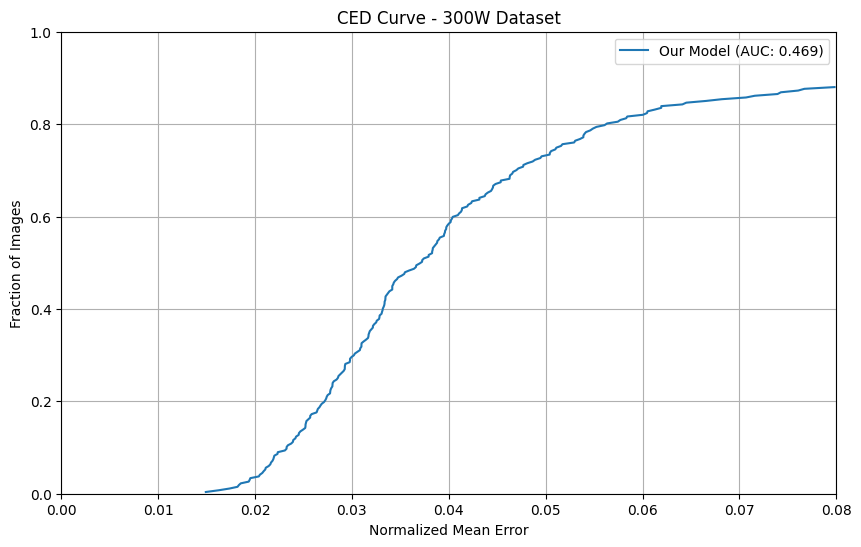

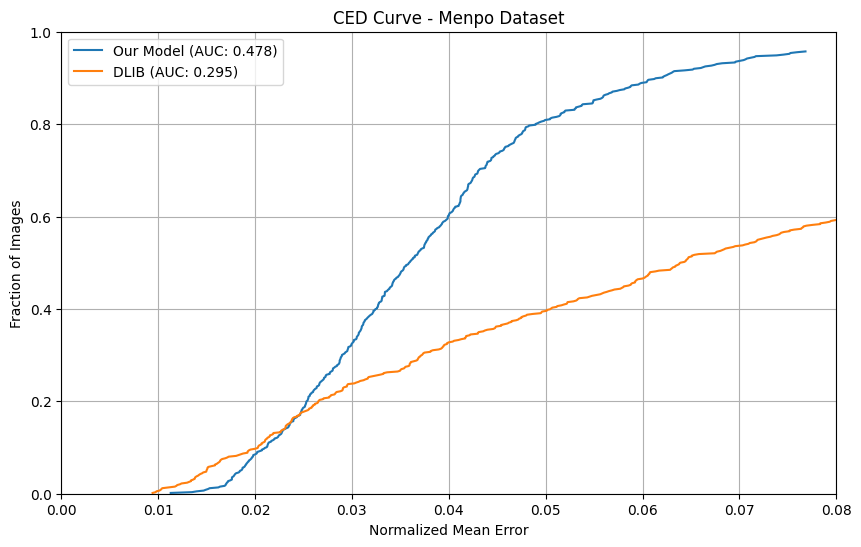


Results Summary:
{
    "300W": {
        "Our Model": {
            "mean": 0.23683049520346605,
            "std": 0.9740538669017612,
            "median": 0.037240441860140985,
            "max": 9.561188271701843,
            "min": 0.014921561803483877,
            "samples": 267
        }
    },
    "Menpo": {
        "Our Model": {
            "mean": 0.04750043348899459,
            "std": 0.07758906056668623,
            "median": 0.035948351758618775,
            "max": 0.9026268820944997,
            "min": 0.01129538664513567,
            "samples": 586
        },
        "DLIB": {
            "mean": 0.08267464459197721,
            "std": 0.08690287272351302,
            "median": 0.06409792061748407,
            "max": 0.8168000481659248,
            "min": 0.009426320635706297,
            "samples": 586
        }
    }
}


In [16]:
# Пути к тестовым данным
test_dirs = [
    "unzipped_300W_dataset/300W/test",
    "unzipped_Menpo_dataset/Menpo/test"
]

# Загрузка модели
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CustomPFLD().to(device)
model.load_state_dict(torch.load('best_model.pth', map_location=device))

# Запуск тестирования
results = evaluate_model(model, test_dirs, device)